# Parte 1
## 1.

In [1]:
using Plots, DSP, MAT, Statistics, DigitalComm

function u(θᵢ, d)
    return d*sind(θᵢ)/c
end

function B(θᵢ, θⱼ, d)
    return (1/M).*(1 .-exp.(im*Ω*M*(u.(θᵢ, d) .- u(θⱼ, d)))) ./ (1 .- exp.(im*Ω*(u.(θᵢ, d) .- u(θⱼ, d))))
end

function v(θᵢ, d)
    m = collect(range(start=0, length=M, step=1))
    return exp.(im*Ω*m*u.(θᵢ', d))
end

v (generic function with 1 method)

In [2]:
# global variables
M = 8
Ω = 60 * 10^9 * 2π
c = 3 * 10^8
θ = (-90:0.1:90)
λ = c/(Ω/2π);

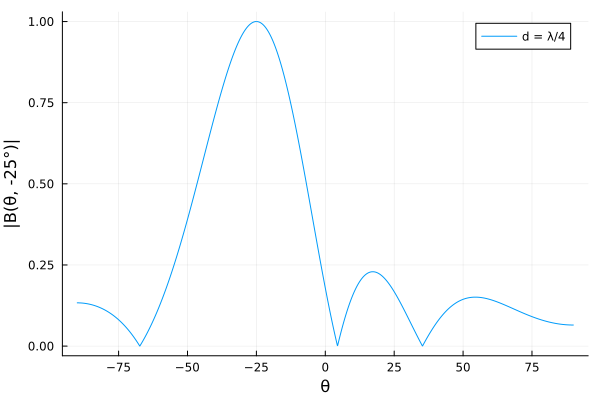

In [3]:
function ex1_1()
    θ₀ = -25
    d = λ/4
    B₁ = B(θ, θ₀, d)
    plot(θ, abs.(B₁), label="d = λ/4")
    plot!(ylabel="|B(θ, -25°)|", xlabel="θ")
end

ex1_1()


## 2.

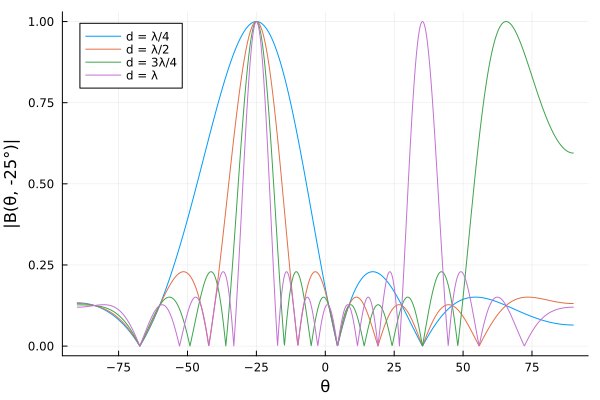

In [4]:
function ex1_2()
    θ₀ = -25
    d = λ/4
    B₁ = B(θ, θ₀, d)
    d = λ/2
    B₂ = B(θ, θ₀, d)
    d = 3λ/4
    B₃ = B(θ, θ₀, d)
    d = λ
    B₄ = B(θ, θ₀, d)
    plot(θ, abs.(B₁), label="d = λ/4")
    plot!(ylabel="|B(θ, -25°)|", xlabel="θ")
    plot!(θ, abs.(B₂), label="d = λ/2")
    plot!(θ, abs.(B₃), label="d = 3λ/4")
    plot!(θ, abs.(B₄), label="d = λ")
end

ex1_2()


Nota-se que ao aumentar o parâmetro d, o lóbulo principal fica mais fino. Porém, para d > λ/2 outros ângulos não desejados começam a passar pelo filtro

## 3.

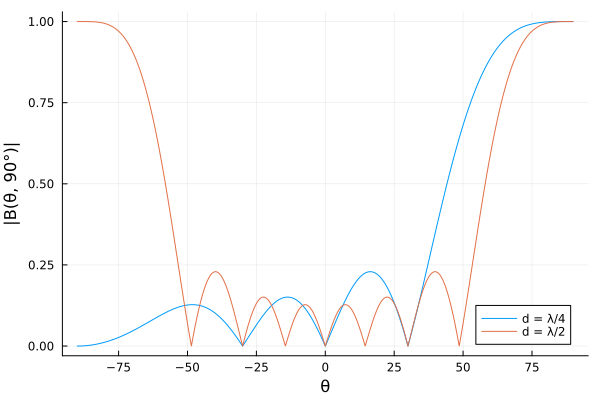

In [5]:
function ex1_3()
    θ₀ = 90
    d = λ/4
    B₅ = B(θ, θ₀, d)
    plot(θ, abs.(B₅), label="d = λ/4", ylabel="|B(θ, 90°)|", xlabel="θ")
    d = λ/2
    B₆ = B(θ, θ₀, d)
    plot!(θ, abs.(B₆), label="d = λ/2")
end

ex1_3()


O problema obserado aqui é que, no caso anterior, um d de λ/2 não era grande suficiente para criar mais de um pico, porém nesse caso, como o pico principal se encontra na extremidade direita do gráfico, há espaço suficiente no meio para surgir outro pico na extremidade esquerda.

## 4.

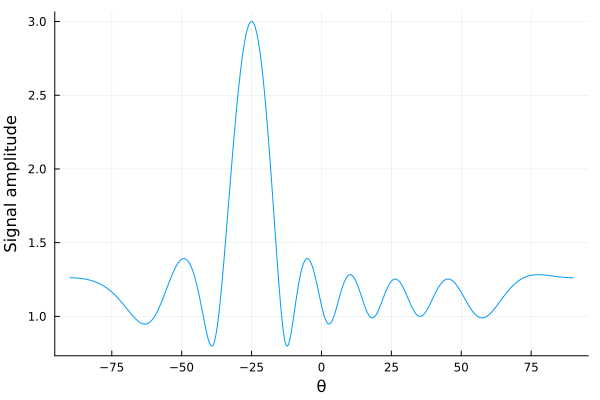

In [6]:
function ex1_4()
    θ₀ = -25
    d = λ/2
    y₁ = 1
    y₂ = 2 .*B(θ, θ₀, d)
    y = y₁.+y₂
    plot(θ, abs.(y), label=false)
    plot!(ylabel="Signal amplitude", xlabel="θ")
end

ex1_4()


# Parte 2
## 1.

In [7]:
# Defining the filter
fₐ = 10^12
ωₙ = Ω/fₐ
lpButter = digitalfilter(Lowpass(ωₙ/π), Butterworth(6))

#reading the files
msg_file = matopen("Dados/mensagem.mat")
msg_true = Array{Int64}(read(msg_file)["mensagem"][:, 1])

x_file = matopen("Dados/sinais.mat")
x₁ = read(x_file)["sinal_recebido"]
t = collect(range(start=0, length=size(x₁)[1], step=1/fₐ));

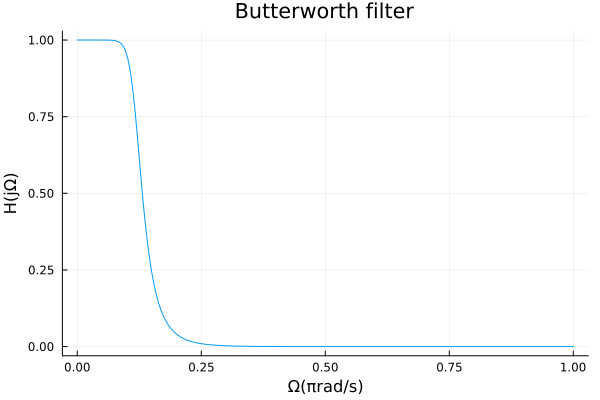

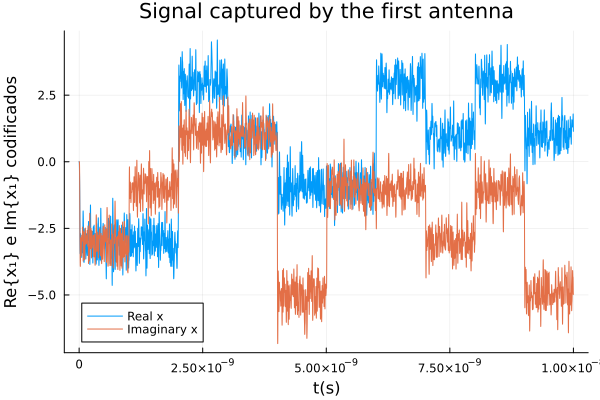

In [19]:
function ex2_1(x)
    ω = range(0, π, length=500)
    H = freqresp(lpButter, ω)
    plt = plot(ω/π, abs.(H),title="Butterworth filter", label=false, ylabel="H(jΩ)", xlabel="Ω(πrad/s)")
    display(plt)
    
    x₁ = copy(x)[:, 1] #signal received by the first antenna
    x̃ᵢ₁ = x₁ .* 2cos.(Ω.*t)
    x̃ⱼ₁ = x₁ .* (-2)sin.(Ω.*t)

    xᵢ₁ = filt(lpButter, x̃ᵢ₁)
    xⱼ₁ = filt(lpButter, x̃ⱼ₁)
    plot(t, xᵢ₁, label="Real x", title="Signal captured by the first antenna", ylabel="Re{x₁} e Im{x₁} codificados", xlabel="t(s)")
    plot!(t, xⱼ₁, label="Imaginary x")
end

ex2_1(x₁)

## 2.

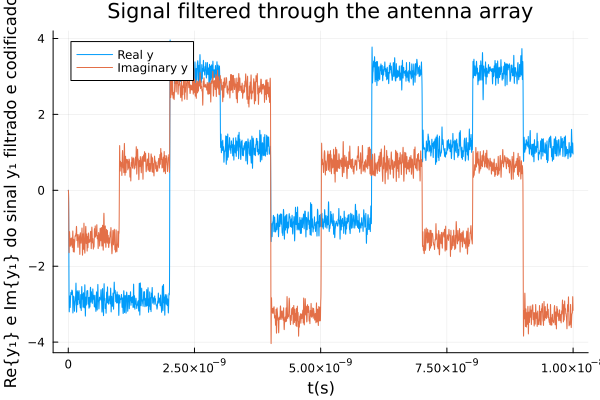

In [21]:
function ex2_2(x)
    d = λ/2 #Como o sinal de interesse vem do ângulo 20°, que é distante de +/- 90°, escolher d = λ/2 garante filtragem espacial boa, sem o aparecimento de um segundo lóbulo
    θ₀ = 20
    v₀ = v(θ₀, d)
    wᴴ = conj(transpose(1/M .* v₀))
    
    x̃ᵢ = copy(x) .*2cos.(Ω.*t)
    xᵢ = filt(lpButter, x̃ᵢ)
    x̃ⱼ = copy(x) .*(-2)sin.(Ω.*t)
    xⱼ = filt(lpButter, x̃ⱼ)

    x̂ = xᵢ .+ im .* xⱼ
    y = wᴴ*transpose(x̂)
    y = y[1, :]
    return y
end

function plot2_2(y)
    yᵢ = real.(y)
    yⱼ = imag.(y)
    plot(t, real.(y), label="Real y", title="Signal filtered through the antenna array", ylabel = "Re{y₁} e Im{y₁} do sinal y₁ filtrado e codificado",
    xlabel = "t(s)")
    display(plot!(t, imag.(y), label="Imaginary y"))
end

y₁ = ex2_2(x₁)
plot2_2(y₁)

## 3.
Se a frequência de amostragem é 1THz e casa símbolo é transmitido por 1 ns, a quantidade de amostras por símbolo é 1e-9/1e-12 = 1000 amostras
A matriz guardada no arquivo tem dimensão (10000, 8), ou seja 8 antenas e 10000 amostras, se há 1000 amostras por símbolo, a quantidade de símbolos transmitidos foi 10000/1000 = 10 símbolos

In [10]:
function ex2_3(y)
    simbols = zeros(ComplexF64, 10)
    for i in (1:10)
        simbols[i] = mean(y[1000*(i-1) + 1 : 1000*i])
    end
    return simbols
end
ex2_3(y₁)

10-element Vector{ComplexF64}:
  -2.836612889389295 - 1.2676447762269374im
 -2.9085675138519718 + 0.6925621943092214im
  3.0486209026350792 + 2.7170515240424353im
  1.1388729997046543 + 2.7045613745978923im
 -0.8479871528651081 - 3.2224324189948117im
 -0.8424507520693189 + 0.6965009501745141im
   3.078740665797177 + 0.6890988146847298im
  1.1532149259834141 - 1.2703541051516831im
  3.1114349955505256 + 0.6658550476139723im
  1.1477691468495201 - 3.252609686905438im

## 4.

In [11]:
function thresholds(simbol)
    if simbol < -2
        simbol = -3
    elseif  simbol < 0
        simbol = -1
    elseif simbol < 2
        simbol = 1
    else
        simbol = 3
    end
    return simbol
end;

In [12]:
function decode_QAM(encoded)
    if (real(encoded) == -3)
        if (imag(encoded) == 3)
            return 0
        elseif (imag(encoded) == 1)
            return 1
        elseif (imag(encoded) == -3)
            return 2
        elseif (imag(encoded) == -1)
            return 3
        end
    end
    if (real(encoded) == -1)
        if (imag(encoded) == 3)
            return 4
        elseif (imag(encoded) == 1)
            return 5
        elseif (imag(encoded) == -3)
            return 6
        elseif (imag(encoded) == -1)
            return 7
        end
    end
    if (real(encoded) == 3)
        if (imag(encoded) == 3)
            return 8
        elseif (imag(encoded) == 1)
            return 9
        elseif (imag(encoded) == -3)
            return 10
        elseif (imag(encoded) == -1)
            return 11
        end
    end
    if (real(encoded) == 1)
        if (imag(encoded) == 3)
            return 12
        elseif (imag(encoded) == 1)
            return 13
        elseif (imag(encoded) == -3)
            return 14
        elseif (imag(encoded) == -1)
            return 15
        end
    end
end;

## 5.

In [13]:
function encode_QAM(decoded::UInt8)
    bit34 = (decoded & 0x0c) >>> 2
    bit12 = decoded & 0x03
    re = 0
    j = 0
    if bit34 == 0x00
        re = -3
    elseif bit34 == 0x01
        re = -1
    elseif bit34 == 0x02
        re = 3
    elseif bit34 == 0x03
        re = 1
    end

    if bit12 == 0x00
        j = 3
    elseif bit12 == 0x01
        j = 1
    elseif bit12 == 0x02
        j = -3
    elseif bit12 == 0x03
        j = -1
    end

    return re + im*j
end;

Received Message: [3, 1, 8, 12, 6, 5, 9, 15, 9, 14]
Expected Message: [3, 1, 8, 12, 6, 5, 9, 15, 9, 14]


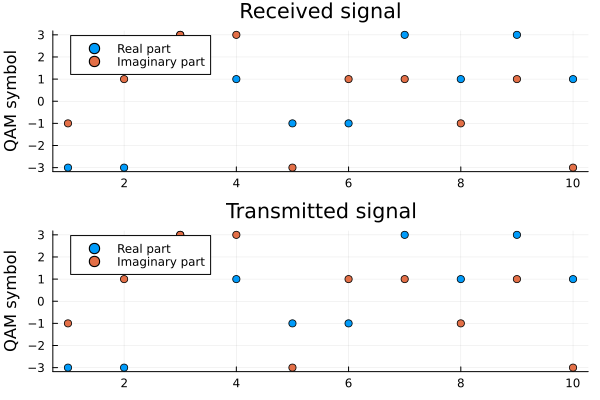

In [14]:
function ex2_5(simbols, title)
    QAMᵣ = thresholds.(real.(simbols))
    QAMᵢ = thresholds.(imag.(simbols))
    encoded_QAM = QAMᵣ + im * QAMᵢ
    decoded_QAM = decode_QAM.(encoded_QAM)
    print("Received Message: ")
    println(decoded_QAM)
    print("Expected Message: ")
    println(msg_true)
    ideal_sig = encode_QAM.(Array{UInt8}(msg_true))
    scatter(1:10, real.(encoded_QAM), title=title, label="Real part", ylabel="QAM symbol")
    p1 = scatter!(1:10, imag.(encoded_QAM), label="Imaginary part")
    scatter(1:10, real.(ideal_sig), label="Real part", ylabel="QAM symbol")
    p2 = scatter!(1:10, imag.(ideal_sig), title="Transmitted signal", label="Imaginary part")
    display(plot(p1, p2, layout=(2, 1)))
end

ex2_5(ex2_3(y₁), "Received signal")

# 6.

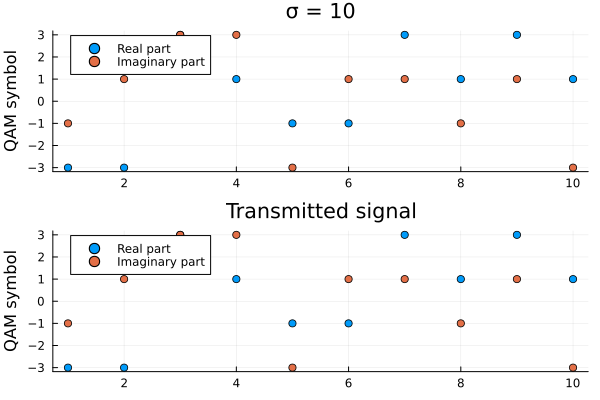

White noise with mean 10
Received Message: [3, 1, 8, 12, 6, 5, 9, 15, 9, 14]
Expected Message: [3, 1, 8, 12, 6, 5, 9, 15, 9, 14]
------------------------------
White noise with mean 30
Received Message: [3, 1, 8, 12, 6, 7, 9, 15, 9, 14]
Expected Message: [3, 1, 8, 12, 6, 5, 9, 15, 9, 14]
------------------------------
White noise with mean 50
Received Message: [3, 1, 8, 8, 6, 7, 9, 7, 8, 14]
Expected Message: [3, 1, 8, 12, 6, 5, 9, 15, 9, 14]


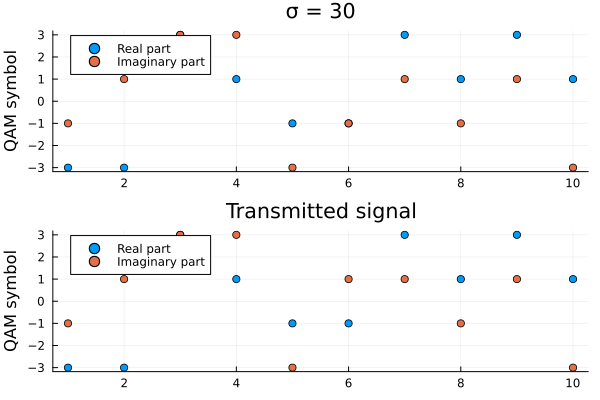

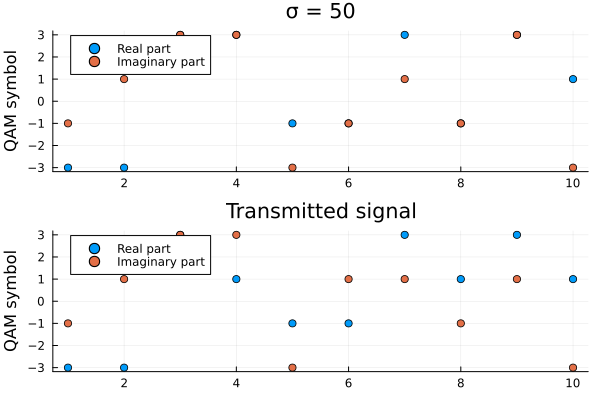

In [24]:
function ex2_6(x)
    white_noise = 10 * randn(Float64, size(x))
    x₂ = x₁ + white_noise
    x₃ = x₁ + 3 * white_noise
    x₄ = x₁ + 5 * white_noise

    y₂ = ex2_2(x₂)
    y₃ = ex2_2(x₃)
    y₄ = ex2_2(x₄)

    simbols₂ = ex2_3(y₂)
    simbols₃ = ex2_3(y₃)
    simbols₄ = ex2_3(y₄)

    println("White noise with mean 10")
    ex2_5(simbols₂, "σ = 10")
    println("------------------------------")
    println("White noise with mean 30")
    ex2_5(simbols₃, "σ = 30")
    println("------------------------------")
    println("White noise with mean 50")
    ex2_5(simbols₄, "σ = 50")

end
ex2_6(x₁)
    

Como é possivel perceber pela comparação das mensagens recebidas com a mensagem esperada, o sistema consegue consistentemente distiguir corretamente entre os símbolos, mesmo com ruído branco de desvio padrão 30. No entando um desvio padrão de 50 já causa o sistema a cometer alguns erros.